In [12]:
%matplotlib widget
from ipywidgets import interact, interactive, fixed, interact_manual
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import modrec.radioml
import modrec.training

In [5]:
seed  =  2016
dataset_name = "2016.10a"

In [10]:
modrec.training.set_seed(seed)
classes, data = modrec.radioml.load_numpy(os.path.join('../data/', dataset_name + '.h5')) 
train, validate, test = modrec.training.split_training(data, 0.5, 0.5)
# models = ['vtcnn2', 'resnet18-outer', 'resnet18-gasf', 'resnet18-gadf']
models = ['resnet18-noisy-outer']
df = pd.DataFrame()
df['ms'] = validate['ms']
df['snr'] = validate['snr']

for model_name in models:
    
    trainer = modrec.training.Trainer('../models', dataset_name, model_name, seed)
    
    df['ms_' + model_name] = list(np.argmax(trainer.load_predictions(), axis=1))

In [ ]:
import pickle
# file = open("/home/aa4239/modrec/models/history/2016.10b/resnet18-outer/2016.pkl", "rb")
# history = pickle.load(file)
# # print(history['acc'])
# import os

scores = {} # scores is an empty dict already
#'0.7drp_2016b'
for i in ['0.5drp_2016b', '0.7drp_2016b']:
    target = f"/home/aa4239/modrec/{i}/history/2016.10b/resnet18-outer/2016.pkl"
    if os.path.getsize(target) > 0:      
        with open(target, "rb") as f:
            # if file is not empty scores will be equal
            # to the value unpickled
            scores = pickle.load(f)
            epochs = range(1,len(scores[0]['accuracy'])+1)
            plt.plot(epochs, scores[0]['accuracy'], label="Training accuracy"+ str(i))
            plt.plot(epochs, scores[0]['val_accuracy'], label="Validation accuracy"+ str(i))
            plt.title('Training and Validation accuracy on 2016b using resnet18-outer')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.savefig("sample.png")

        

# print(scores[0]['accuracy'])

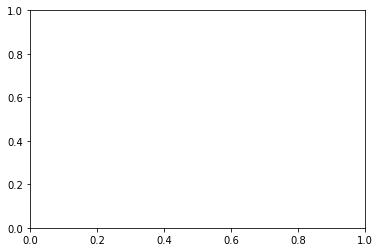

interactive(children=(IntSlider(value=9, description='i', max=19), Dropdown(description='model_name', options=…

<function __main__.interactive_confusion_matrix.<locals>.f(i, model_name)>

In [1]:
from ipywidgets import interact, interactive, fixed, interact_manual
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import modrec.radioml
import modrec.training
dataset_name = '2016.10a'
seed = 2016
# models = ['vtcnn2', 'resnet18-outer', 'resnet18-gasf', 'resnet18-gadf']
#'resnet18-mtf', 'resnet18-gasf', 'resnet18-gadf', 'vtcnn2'
models = ['resnet18-outer-noisy']
modrec.training.set_seed(seed)
classes, data = modrec.radioml.load_numpy(os.path.join('../data/', dataset_name + '.h5')) 
train, validate, test = modrec.training.split_training(data, 0.5, 0.5)
df = pd.DataFrame()
df['ms'] = validate['ms']
df['snr'] = validate['snr']

for model_name in models:
#     trainer = modrec.training.Trainer('../models', dataset_name, model_name, seed)   
#     np.load(self.predictions_path)
    df['ms_' + model_name] = list(np.argmax(np.load("/media/arrowhead/WD21/modrec/models/predictions/2016.10a/resnet18-noisy-outer/2016.npy"), axis=1))

def plot_confusion_matrix(fig, ax, cm, title='Confusion matrix', labels=[], grid=False, cmap=plt.cm.viridis):
    # Assume colorbar was plotted last
    if len(ax.images) > 0:
        cb = ax.images[-1].colorbar   
        cb.remove()

    ax.clear()

    image = ax.imshow(cm, interpolation='nearest', cmap=cmap, clim=(0,1))
    cb = fig.colorbar(image)
    
    tick_marks = np.arange(len(labels))
    if grid:
        ax.grid(grid, color='w')
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(labels)

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title(title)
    
    fig.tight_layout()

def plot_confusion(fig, ax, df, model_name, snr=None):
    if snr is not None:
        plot_df = df[df.snr == snr]
    else:
        plot_df = df

    confusion_matrix = pd.crosstab(plot_df.ms, plot_df['ms_' + model_name],
                                   rownames=['actual'],
                                   colnames=['predicted'])
    correct = np.sum(np.diag(confusion_matrix.to_numpy()))
    total = len(plot_df)
    print("Accuracy: %g" % (correct/total))

    if snr is None:
        title = None
    else:
        title = f"Confusion Matrix (SNR={snr:g})"

    plot_confusion_matrix(fig, ax, confusion_matrix/confusion_matrix.sum(axis=1),
                          title=title,
                          labels=list(classes))

def interactive_confusion_matrix():
    fig, ax = plt.subplots()

    snrs = sorted(df.snr.unique())

    def f(i, model_name):
        if len(ax.images) != 0:
            cb = ax.images[-1].colorbar
            cb.remove()

        ax.clear()
        
        plot_confusion(fig, ax, df, model_name, snr=snrs[i])

    return interact(f, i=(0,len(snrs)-1), model_name=models)

interactive_confusion_matrix()


In [15]:
def compute_accuracy(df, model_name):
    df['correct'] = df.ms == df['ms_' + model_name]
    df_accuracy = df.groupby('snr')['correct'].aggregate(['count', 'sum'])
    return (df.correct.sum()/df.correct.count(), df_accuracy['sum'] / df_accuracy['count'])

LABELS = { 'vtcnn2': 'CNN2 Dropout 0.5',
         'resnet18-outer': 'OUT+OUT+OUT'
         , 'resnet18-gasf': 'GASF+OUT+OUT'
         , 'resnet18-gadf': 'GADF+OUT+OUT'
          , 'resnet18-mtf' : 'MTF+OUT+OUT'
          , 'resnet18-noisy-outer': 'OUT+OUT+OUT with noise'
         }

snrs = sorted(df.snr.unique())

fig, ax = plt.subplots()

fig.suptitle("Classification Accuracy on RadioML" + dataset_name)

for model_name in models:
    accuracy, per_snr_accuracy = compute_accuracy(df, model_name)

    ax.plot(snrs, per_snr_accuracy, marker='.', label=LABELS[model_name], linewidth=1)
    
    ax.set_xlabel("Signal to Noise Ratio")
    ax.set_ylim(0,1)
    ax.set_ylabel("Classification Accuracy")
    ax.legend()
    plt.savefig("noisy.png")

    print('%s accuracy: %g' % (LABELS[model_name], accuracy))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

OUT+OUT+OUT with noise accuracy: 0.158482
